In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from collections import Counter
import scipy.stats as ss
import math

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

# To build and evaluate model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

plt.rcParams['figure.figsize'] = (10,6)
sns.set_palette(sns.color_palette("hls", 8))

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
combine = [train_df, test_df]

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## EDA and Visualization

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


We see that there are 8693 entires. Most features are missing a few values. We can see this from the data info below

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Checking null values as a percentage of records, most features are missing about 2% of their values

In [7]:
round(train_df.isna().sum() * 100/train_df.shape[0], 3)
# train_df.isnull().sum()

PassengerId     0.000
HomePlanet      2.312
CryoSleep       2.496
Cabin           2.289
Destination     2.094
Age             2.059
VIP             2.335
RoomService     2.082
FoodCourt       2.105
ShoppingMall    2.393
Spa             2.105
VRDeck          2.163
Name            2.301
Transported     0.000
dtype: float64

If we simply just drop entries with nulls then we end up with 6606 entries which is too great of a loss in data. (24% reduction) so we need to try to fill in nulls best as we can

In [8]:
train_df.dropna(axis=0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


VIP status is not a strong indicator of whether a passenger is transported or not

In [9]:
px.histogram(data_frame=train_df, x = 'VIP', color='Transported', color_discrete_sequence=px.colors.qualitative.Safe)

Likelihood of being transported decreases with age

In [10]:
df = train_df.sort_values(by='Age')
df['AgeRange'] = pd.cut(train_df.Age, bins = [0.0, 5.0, 12, 20.0, 30.0, 45.0, 55.0, 65.0, 80.0],
     labels = ['0 - 5', '6 - 12', '13 - 20', '21 - 30', '31 - 45', '46 - 55', '56 - 65', '66 - 80'])
px.histogram(data_frame=df, x = 'AgeRange', color='Transported', color_discrete_sequence=px.colors.qualitative.Safe)

Visualizing the distribution of values for the luxurious amenities. Mode is 0 for all

In [11]:
fig = go.Figure()
fig.add_trace(go.Box(y= train_df.RoomService ,name='Room Service', boxmean = True))
fig.add_trace(go.Box(y = train_df.FoodCourt, name= 'Food Court', boxmean = True))
fig.add_trace(go.Box(y = train_df.ShoppingMall, name= 'Shopping mall', boxmean = True))
fig.add_trace(go.Box(y = train_df.Spa, name= 'Spa', boxmean = True))
fig.add_trace(go.Box(y = train_df.VRDeck, name= 'VRDeck', boxmean = True))

In [12]:
df["AmenityBillTotal"] = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]
fig = go.Figure()
fig.add_trace(go.Box(x=df['AgeRange'],y= df.AmenityBillTotal ,name='Room Service', boxmean = True))


Most passengers who were in CryoSleep were Transported

In [13]:
px.histogram(data_frame=train_df, x = 'CryoSleep', color='Transported', color_discrete_sequence=px.colors.qualitative.Safe)

Passengers from Europa are slightly more likely to be transported

In [14]:
px.histogram(data_frame=train_df, x = 'HomePlanet', color='Transported', color_discrete_sequence=px.colors.qualitative.Safe)

Passengers headed for 55 Cancri e are more likely to be transported

In [15]:
px.histogram(data_frame=train_df, x = 'Destination', color='Transported', color_discrete_sequence=px.colors.qualitative.Safe)

We encode the categorical vaiables which only have a few distinct values so we can see if there is correlation/association between other features.

HomePlanet, CryoSleep, Destination and VIP only have a few possible values so can easily be encoded.


In [16]:
train_df.select_dtypes(['object']).nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

Next we generate a heatmap to see correlation between our variables. Interestingly, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck have uniform correlation with CryoSleep. The values for these features represent the amount billed to the passenger for these amenities.

<AxesSubplot:>

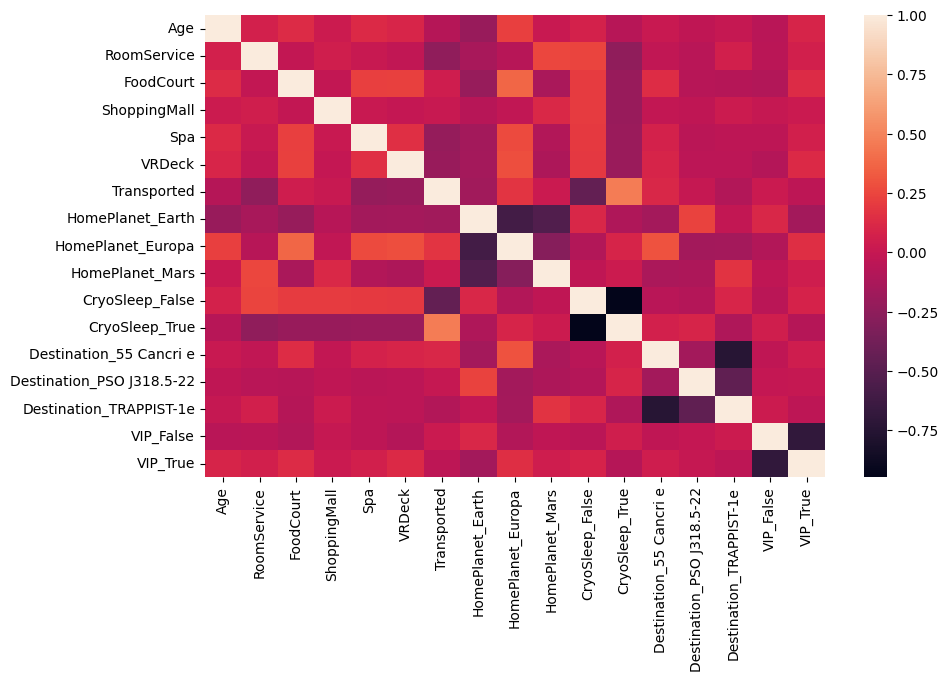

In [17]:
encoded = pd.get_dummies(train_df[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']])
df = train_df.drop(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], axis=1)
df = pd.concat([df,encoded], axis=1)
sns.heatmap(df.corr())

## Filling in missing variables

The categorical variables with missing values and thier number of missing values are shown below

In [18]:
cat_feature_null_totals = train_df.select_dtypes(['object']).isnull().sum()
cat_feature_null_totals[cat_feature_null_totals > 0]

HomePlanet     201
CryoSleep      217
Cabin          199
Destination    182
VIP            203
Name           200
dtype: int64

From the heatmap in EDA, spending on each of the amenitites had uniform correlation with CryoSleep. Looking more closely at this, all passengers who have True values for CryoSleep had 0 spending on the luxurious amenities which makes sense intuitvely because passengers who opted for Cryogenic sleep for the voyage would not have been awake to spend on these amenities.

In [19]:
df[train_df.CryoSleep == True].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
count,2955.000000,2969.0,2967.0,2941.0,2972.0,2975.0,3037.000000,3037.000000,3037.000000,3037.0,3037.0,3037.000000,3037.000000,3037.000000,3037.000000,3037.000000
mean,27.405415,0.0,0.0,0.0,0.0,0.0,0.455054,0.299967,0.220283,0.0,1.0,0.243332,0.126111,0.614751,0.968390,0.006915
std,15.080469,0.0,0.0,0.0,0.0,0.0,0.498058,0.458319,0.414506,0.0,0.0,0.429165,0.332029,0.486734,0.174989,0.082880
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,26.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000000
75%,37.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.0,0.000000,0.000000,1.000000,1.000000,0.000000
max,78.000000,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


We can use this information to fill in some null values. Passengers with 0 values for all or most of these features are probably in CryoSleep although it is possible that some passengers were awake and simply did not use any of the luxaries. Looking at how likely it is that a passenger who was not in CryoSleep was billed 0 for the amenities. There are 470 passengers who were not billed for luxaries but were not in CryoSleep. Therefore we cannot assume that passengers with 0 spending are in CryoSleep 

In [20]:
cryoSleep_false = train_df[train_df.CryoSleep == False]
cryoSleep_false_zero = cryoSleep_false.loc[(cryoSleep_false.RoomService == 0) 
                        & (cryoSleep_false.FoodCourt == 0) & (cryoSleep_false.ShoppingMall==0) 
                        & (cryoSleep_false.Spa==0) & (cryoSleep_false.VRDeck == 0)]
cryoSleep_false_zero.shape

(470, 14)

CryoSleep = True still implies 0 spending on these luxaries so we can fill in these values where CryoSleep = True. Otherwise, if CryoSleep is false we fill in the missing values with the median. All of the luxary amenites (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) now have a reduction in null values.

In [21]:
train_before_filling = train_df.copy()
train_df.loc[train_df.CryoSleep == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0 
test_df.loc[test_df.CryoSleep == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0 
# train_df[train_df.CryoSleep == True].isnull().sum()
before = pd.Series(train_before_filling.isnull().sum(), name='Nulls Before filling on CrySleep=True')
after = pd.Series(train_df.isnull().sum(), name='Nulls After filling on CryoSleep=True')
df=pd.concat([before,after],axis=1)
df


,Nulls Before filling on CrySleep=True,Nulls After filling on CryoSleep=True
PassengerId,0,0
HomePlanet,201,201
CryoSleep,217,217
Cabin,199,199
Destination,182,182
Age,179,179
VIP,203,203
RoomService,181,113
FoodCourt,183,113
ShoppingMall,208,112


Filling in categorical features VIP and CryoSleep based on mode

In [22]:
cat_features = ['VIP', 'CryoSleep']
for dataset in combine:
    for feature in cat_features:
        featureMode = dataset[feature].mode()[0]
        dataset[feature] = dataset[feature].fillna(featureMode)

Mars is chosen for missing homeplanet because it has about 50/50 split for tranported therefore it works as the best neutral guess. Same with PSO for the destination. Decks T and P are the least represented decks and sides resepctively

In [23]:
for dataset in combine:
    dataset['HomePlanet'] =dataset['HomePlanet'].fillna('Mars')
    dataset['Destination']=dataset['Destination'].fillna("PSO J318.5-22")
    dataset['Cabin'] =dataset['Cabin'].fillna('T/0/P')

Age and the luxurious amenities are the remaing features with null values to be filled

In [24]:
train_df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age             179
VIP               0
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Name            200
Transported       0
dtype: int64

Spending on the amenities will be filled on mode and the age will be filled with the median value

In [25]:
for dataset in combine:
    for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])
    dataset.Age = dataset.Age.fillna(dataset.Age.median())
train_df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

## Feature engineering and pre-processing

The cabin feature is in form deck/num/side, where side can be either P for Port or S for Starboard. It makes more sense to split this into separate features.

In [26]:
for dataset in combine:
    dataset[['CabinDeck','CabinNum','CabinSide']] = dataset.Cabin.str.split('/',expand=True)

Total Spending will serve as an indicator of the wealth of the passenger which may have correlation with the likelihood of being transported

In [27]:
for dataset in combine:
    dataset["TotalSpendings"] = dataset["RoomService"] + dataset["FoodCourt"] + dataset["ShoppingMall"] + dataset["Spa"] + dataset["VRDeck"]

In [28]:
train_df.columns.values

array(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination',
       'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa',
       'VRDeck', 'Name', 'Transported', 'CabinDeck', 'CabinNum',
       'CabinSide', 'TotalSpendings'], dtype=object)

From EDA we saw that when grouping by Age, distinct characteristics become apparent 

In [29]:
for dataset in combine:
    dataset['AgeRange']  = 0
    for i in range(6):
        dataset.loc[(dataset.Age >= 10*i) & (dataset.Age < 10*(i+1)),'AgeRange'] = i

Encoding categorical features

In [30]:
categorical_cols = ['HomePlanet','CryoSleep','Destination','VIP','CabinDeck','CabinSide','CabinNum']
for i in categorical_cols:
    label_encoder = LabelEncoder()
    combination = np.concatenate((train_df[i], test_df[i])).astype(str)
    label_encoder.fit(combination)
    train_df[i]=label_encoder.transform(train_df[i].astype(str))
    test_df[i]=label_encoder.transform(test_df[i].astype(str))

Dropping features which are now useless

In [31]:
columns_to_drop = ["Cabin", "Name", 'PassengerId']
for dataset in combine:
    dataset.drop(columns_to_drop, axis = 1, inplace=True)

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8693 non-null   int64  
 1   CryoSleep       8693 non-null   int64  
 2   Destination     8693 non-null   int64  
 3   Age             8693 non-null   float64
 4   VIP             8693 non-null   int64  
 5   RoomService     8693 non-null   float64
 6   FoodCourt       8693 non-null   float64
 7   ShoppingMall    8693 non-null   float64
 8   Spa             8693 non-null   float64
 9   VRDeck          8693 non-null   float64
 10  Transported     8693 non-null   bool   
 11  CabinDeck       8693 non-null   int64  
 12  CabinNum        8693 non-null   int64  
 13  CabinSide       8693 non-null   int64  
 14  TotalSpendings  8693 non-null   float64
 15  AgeRange        8693 non-null   int64  
dtypes: bool(1), float64(7), int64(8)
memory usage: 1.0 MB


## Model

In [33]:
X_train = train_df.copy()
y_train = train_df["Transported"].astype(int)
X_train.drop(['Transported'], axis=1, inplace=True)

X_test = test_df.copy()

In [34]:
X_train.head()
# X_train.info()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinNum,CabinSide,TotalSpendings,AgeRange
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,3
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,5,0,1,736.0,2
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,10383.0,5
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,5176.0,3
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,5,1,1,1091.0,1


Using CatBoost with grid search to optimize parameters

In [35]:
# cb = CatBoostClassifier(iterations=1500,
#                           eval_metric='Accuracy',
#                           verbose = 0)
grid=GridSearchCV(CatBoostClassifier(),param_grid={'iterations': range(200,2000,200), 'eval_metric': ['Accuracy'],
                                                   'verbose':[0]},cv=3)
grid.fit(X_train,y_train)
Y_pred = grid.predict(X_train)
acc = accuracy_score(y_train,Y_pred)
acc

0.876567353042678

Using our final model to perform classification on the test data

In [36]:
Y_pred = grid.predict(X_test)

test_df = pd.read_csv('./test.csv')
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Transported": Y_pred.astype(bool)
    })
submission.to_csv('./submission.csv', index=False)